In [1]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 835.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install pyngrok

In [3]:
!ngrok config add-authtoken 2uSJDwd4cyVtmq9GRXlCmxie3nn_MPeADKnhjhQUGnmMCmxj

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
from pyngrok import ngrok
ngrok.set_auth_token("2uSJDwd4cyVtmq9GRXlCmxie3nn_MPeADKnhjhQUGnmMCmxj")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import pickle

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")


In [6]:
# Load the file
file_path = "/content/data/state_level_data.csv"
df = pd.read_csv(file_path)

# Parse date and select latest rent per city
df['Date'] = pd.to_datetime(df['Date'])
city_rent = df[['Date', 'RegionName', 'AllHomesRent']].dropna()
latest_date = city_rent['Date'].max()
latest_rent_by_city = city_rent[city_rent['Date'] == latest_date]

# Compute top 10 cities by average rent
top_cities = (
    latest_rent_by_city.groupby('RegionName')['AllHomesRent']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("Top Cities by Rent")

top_cities.head(10)



Top Cities by Rent


,RegionName,AllHomesRent
0,"New York, NY",3428.026374
1,"San Jose, CA",3426.844794
2,"Boston, MA",3190.367880
3,"San Francisco, CA",3108.817765
4,"San Diego, CA",3071.423380
5,"Los Angeles, CA",2995.398850
6,"Naples, FL",2855.644509
7,"Miami, FL",2778.965299
8,"Riverside, CA",2564.941961
9,"Port St. Lucie, FL",2458.564185


In [7]:
citywise_forecasts = {}

In [8]:
# Filter New York, NY data again
ny_ts = df[df['RegionName'] == 'New York, NY'][['Date', 'AllHomesRent']]
ny_ts = ny_ts.set_index('Date').asfreq('ME')

# Fit ARIMA (SARIMAX with default seasonal order)
model = SARIMAX(ny_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(ny_ts.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
})
citywise_forecasts['New York, NY'] = forecast_df

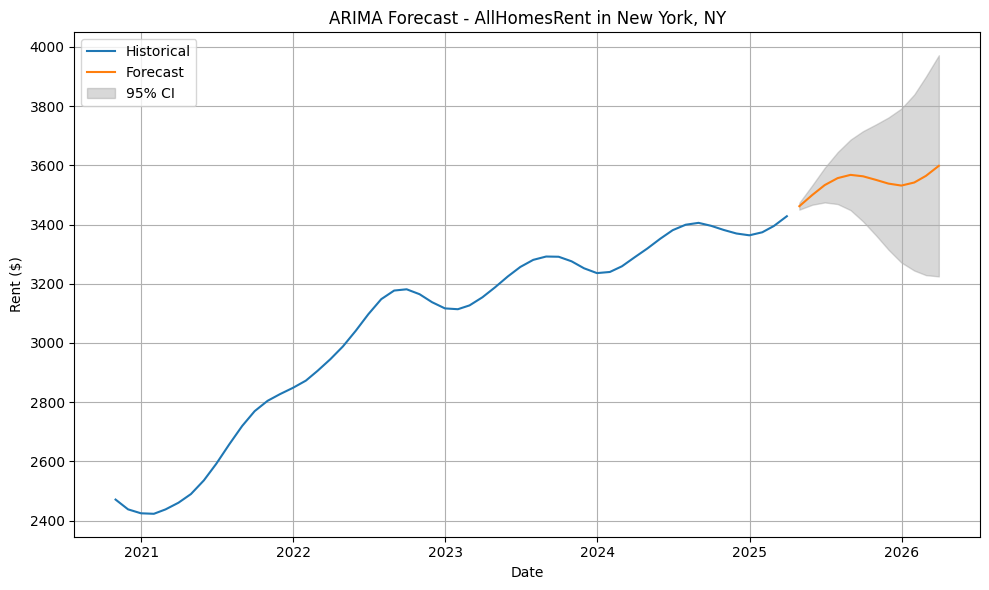

,Date,Forecast,Lower CI,Upper CI
2025-04-30,2025-04-30,3461.926624,3450.230834,3473.622413
2025-05-31,2025-05-31,3499.674991,3466.790118,3532.559865
2025-06-30,2025-06-30,3533.266614,3474.645373,3591.887855
2025-07-31,2025-07-31,3556.783105,3469.135164,3644.431046
2025-08-31,2025-08-31,3567.734238,3448.591519,3686.876957
2025-09-30,2025-09-30,3562.914577,3410.390846,3715.438309
2025-10-31,2025-10-31,3550.819528,3363.463987,3738.175070
2025-11-30,2025-11-30,3538.273462,3314.973301,3761.573623
2025-12-31,2025-12-31,3531.614243,3271.525582,3791.702904
2026-01-31,2026-01-31,3541.956490,3244.453191,3839.459789


In [9]:
# Plot actual + forecast
plt.figure(figsize=(10, 6))
plt.plot(ny_ts.index, ny_ts['AllHomesRent'], label='Historical')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast - AllHomesRent in New York, NY")
plt.xlabel("Date")
plt.ylabel("Rent ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df

### Key Observations

#### **Upward Rent Trend**
- Historical data from 2021 to 2025 shows a steady increase in rents, climbing from around **$2,400 - $3,400**.

- The upward trajectory suggests **persistent demand or supply constraints** in the NYC rental market.

#### **Seasonality Evident**
- Rents show **cyclical fluctuations** (likely seasonal), with peaks and troughs roughly aligned to annual patterns.

#### **Forecasted Growth**
- ARIMA predicts rents to **continue rising through mid-2026**, with the forecast line reaching around **$3,600** by the end of the horizon.

#### **Uncertainty Range**
- The **95% confidence interval (CI)** widens significantly beyond 2025, ranging from approximately **$3,250 - $3,950** by early 2026.
- This reflects **higher uncertainty** over long-term rent projections.

#### **Stabilization Signs**
- While growth is forecasted, the **slope of the forecast line is flatter** compared to past years, suggesting a potential **moderation in rent increases**.


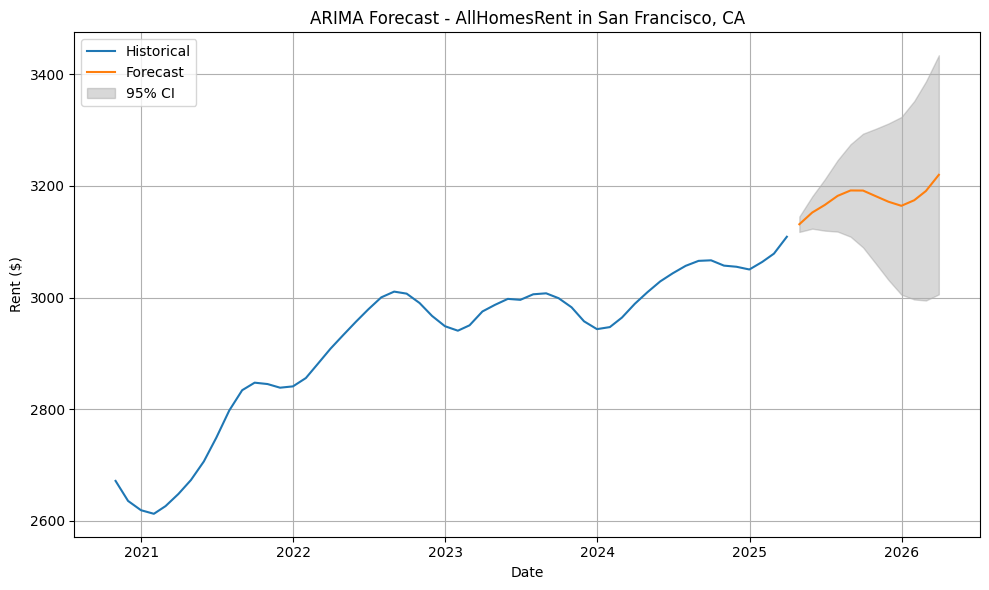

,Date,Forecast,Lower CI,Upper CI
2025-04-30,2025-04-30,3131.204043,3117.432269,3144.975816
2025-05-31,2025-05-31,3152.243007,3123.312149,3181.173866
2025-06-30,2025-06-30,3165.713161,3119.788337,3211.637986
2025-07-31,2025-07-31,3182.064461,3118.031319,3246.097603
2025-08-31,2025-08-31,3191.721635,3108.938190,3274.505081
2025-09-30,2025-09-30,3191.552265,3089.697731,3293.406799
2025-10-31,2025-10-31,3181.324096,3060.302142,3302.346050
2025-11-30,2025-11-30,3171.562447,3031.435859,3311.689034
2025-12-31,2025-12-31,3164.248611,3005.193367,3323.303856
2026-01-31,2026-01-31,3174.265221,2996.537503,3351.992940


In [10]:
# Filter San Francisco, CA data again
sf_ts = df[df['RegionName'] == 'San Francisco, CA'][['Date', 'AllHomesRent']]
sf_ts = sf_ts.set_index('Date').asfreq('ME')

# Fit ARIMA (SARIMAX with default seasonal order)
model = SARIMAX(sf_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(sf_ts.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
})
citywise_forecasts['San Francisco, CA'] = forecast_df


# Plot actual + forecast
plt.figure(figsize=(10, 6))
plt.plot(sf_ts.index, sf_ts['AllHomesRent'], label='Historical')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast - AllHomesRent in San Francisco, CA")
plt.xlabel("Date")
plt.ylabel("Rent ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df

### Key Observations – San Francisco, CA

#### **Moderate Upward Rent Trend**
- From 2021 to 2025, rents rose from around **$2,600 - $3,150**, reflecting a steady but slower growth pace compared to markets like New York.
- Indicates **stable demand growth** despite market fluctuations.

#### **Seasonal Variability**
- The historical rent pattern shows **clear seasonal fluctuations**, with recurring dips and rebounds aligned to yearly cycles.

#### **Forecasted Growth into 2026**
- Rents are projected to **increase modestly**, reaching around **$3,200** by mid-2026.
- Growth is more stable and less aggressive than New York’s projected trend.

#### **Uncertainty in Forecast**
- The **95% confidence interval (CI)** widens significantly beyond 2025, spanning roughly **$3,000 - $3,430** by early 2026.
- Reflects **increased uncertainty** over longer-term rental trends.

#### **Signs of Plateauing**
- The forecasted rent trajectory **flattens**, suggesting **potential stabilization** rather than strong growth through 2026.


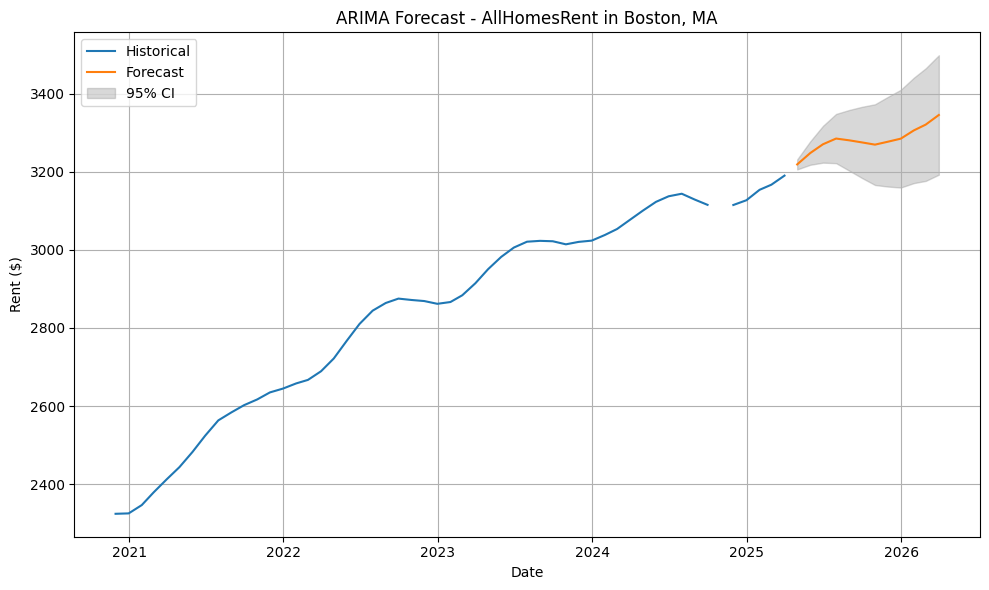

,Date,Forecast,Lower CI,Upper CI
2025-04-30,2025-04-30,3219.057631,3206.191904,3231.923357
2025-05-31,2025-05-31,3248.275775,3218.117808,3278.433743
2025-06-30,2025-06-30,3270.722009,3223.553163,3317.890854
2025-07-31,2025-07-31,3285.333034,3222.254960,3348.411108
2025-08-31,2025-08-31,3280.819034,3203.112606,3358.525462
2025-09-30,2025-09-30,3275.491947,3184.384825,3366.599069
2025-10-31,2025-10-31,3269.750908,3166.337495,3373.164321
2025-11-30,2025-11-30,3277.107616,3162.359247,3391.855986
2025-12-31,2025-12-31,3285.088786,3159.825950,3410.351622
2026-01-31,2026-01-31,3306.276860,3171.192722,3441.360998


In [11]:
# Filter Boston, MA data again
boston_ts = df[df['RegionName'] == 'Boston, MA'][['Date', 'AllHomesRent']]
boston_ts = boston_ts.set_index('Date').asfreq('ME')

# Fit ARIMA (SARIMAX with default seasonal order)
model = SARIMAX(boston_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(boston_ts.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
})
citywise_forecasts['Boston, MA'] = forecast_df


# Plot actual + forecast
plt.figure(figsize=(10, 6))
plt.plot(boston_ts.index, boston_ts['AllHomesRent'], label='Historical')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast - AllHomesRent in Boston, MA")
plt.xlabel("Date")
plt.ylabel("Rent ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df

### Key Observations – Boston, MA

#### **Consistent Upward Rent Trend**
- From 2021 to 2025, rents increased from about **$2,300** to nearly **$3,200**, showing **steady year-over-year growth**.
- Reflects Boston’s sustained demand for rental housing.

#### **Seasonality with Minor Variability**
- Historical rents display **seasonal patterns**, though less pronounced compared to coastal cities like New York or San Francisco.

#### **Forecasted Growth into 2026**
- ARIMA projects rents to **rise moderately**, reaching around **$3,350** by mid-2026.
- Growth pace remains steady, without sharp spikes.

#### **Uncertainty in Forecast**
- The **95% confidence interval (CI)** expands beyond 2025, ranging roughly from **$3,200 to $3,500** by early 2026.
- Indicates typical long-term forecast uncertainty, but not extreme volatility.

#### **Stable Growth Outlook**
- The forecast line suggests **continued but controlled rent increases**, with no signs of dramatic acceleration or plateauing through 2026.


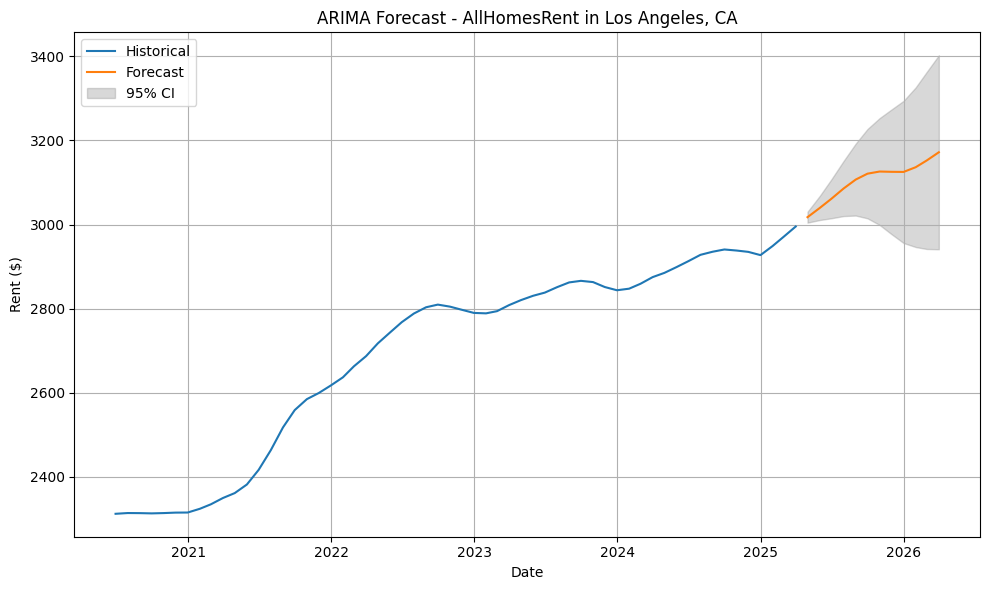

,Date,Forecast,Lower CI,Upper CI
2025-04-30,2025-04-30,3017.530587,3004.541333,3030.519840
2025-05-31,2025-05-31,3039.263385,3010.706505,3067.820265
2025-06-30,2025-06-30,3061.344797,3015.014911,3107.674683
2025-07-31,2025-07-31,3085.651131,3020.162027,3151.140235
2025-08-31,2025-08-31,3106.963599,3021.406265,3192.520933
2025-09-30,2025-09-30,3120.958308,3014.791550,3227.125067
2025-10-31,2025-10-31,3126.070194,2999.011458,3253.128930
2025-11-30,2025-11-30,3125.380438,2977.335312,3273.425563
2025-12-31,2025-12-31,3125.098584,2956.111940,3294.085228
2026-01-31,2026-01-31,3136.330740,2946.551471,3326.110010


In [12]:
# Filter Los Angeles, CA data again
la_ts = df[df['RegionName'] == 'Los Angeles, CA'][['Date', 'AllHomesRent']]
la_ts = la_ts.set_index('Date').asfreq('ME')

# Fit ARIMA (SARIMAX with default seasonal order)
model = SARIMAX(la_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(la_ts.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
})
citywise_forecasts['Los Angeles, CA'] = forecast_df


# Plot actual + forecast
plt.figure(figsize=(10, 6))
plt.plot(la_ts.index, la_ts['AllHomesRent'], label='Historical')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast - AllHomesRent in Los Angeles, CA")
plt.xlabel("Date")
plt.ylabel("Rent ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df

### Key Observations – Los Angeles, CA

#### **Steady Upward Rent Growth**
- From 2021 to 2025, rents increased from about **$2,300** to around **$3,000**, showing **consistent year-over-year growth**.
- Highlights Los Angeles’ **ongoing rental demand and rising housing costs**.

#### **Mild Seasonal Fluctuations**
- Historical data reveals **small seasonal variations**, less pronounced compared to cities like New York or Boston.

#### **Forecasted Growth into 2026**
- ARIMA projects rents to **rise steadily**, reaching about **$3,175–$3,200** by mid-2026.
- Growth pace remains **gradual and stable**, with no sharp surges.

#### **Uncertainty in Forecast**
- The **95% confidence interval (CI)** broadens beyond 2025, ranging roughly from **$2,950 to $3,400** by early 2026.
- This suggests **moderate uncertainty** over long-term rental trends.

#### **Stable Growth Outlook**
- The forecast line indicates **continued, steady rent increases** through 2026 without signs of a major plateau or rapid acceleration.


In [13]:
#import pickle

# Combine all forecast DataFrames into one for easier export and visualization
all_forecasts = []

for city, forecast_df in citywise_forecasts.items():
    forecast_df = forecast_df.copy()
    forecast_df['RegionName'] = city
    all_forecasts.append(forecast_df)

combined_forecasts_df = pd.concat(all_forecasts).reset_index(drop=True)

# Save combined forecast and historical data
historical_df = df[['Date', 'RegionName', 'AllHomesRent']].dropna()

# Save to files
forecast_pkl_path = "/content/data/citywise_forecasts.pkl"
historical_csv_path = "/content/data/historical_rent.csv"

with open(forecast_pkl_path, "wb") as f:
    pickle.dump(citywise_forecasts, f)

historical_df.to_csv(historical_csv_path, index=False)

forecast_pkl_path, historical_csv_path

('/content/data/citywise_forecasts.pkl', '/content/data/historical_rent.csv')

In [14]:
%%bash
cat > forecast.py << 'EOF'


import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Load data
df = pd.read_csv("/content/data/state_level_data.csv", parse_dates=["Date"])
df = df.dropna(subset=["AllHomesRent"])

# 2) Compute top 4 cities and their forecasts
latest = df.Date.max()
top_cities = (
  df[df.Date==latest]
  .groupby("RegionName")["AllHomesRent"]
  .mean()
  .nlargest(4)
  .index
)

citywise_forecasts = {}
city_ts_store = {}
for city in top_cities:
    city_ts = (
        df[df.RegionName==city]
        .set_index("Date")
        .asfreq("ME")["AllHomesRent"]
    )
    model = SARIMAX(city_ts, order=(1,1,1), seasonal_order=(1,1,1,12))
    res = model.fit(disp=False)
    fc = res.get_forecast(12)
    idx = pd.date_range(city_ts.index[-1] + pd.offsets.MonthEnd(1),
                        periods=12, freq="ME")
    fc_df = pd.DataFrame({
      "Date": idx,
      "Forecast": fc.predicted_mean,
      "Lower CI": fc.conf_int().iloc[:,0],
      "Upper CI": fc.conf_int().iloc[:,1]
    })
    citywise_forecasts[city] = fc_df
    city_ts_store[city] = city_ts

# 3) Now your UI
st.title("Rent Forecasts for Top 4 Cities")
for city, forecast_df in citywise_forecasts.items():
    st.subheader(city)
    hist = city_ts_store[city]

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(hist.index, hist, label="Historical")
    ax.plot(forecast_df["Date"], forecast_df["Forecast"], label="Forecast")
    ax.fill_between(
      forecast_df["Date"],
      forecast_df["Lower CI"],
      forecast_df["Upper CI"],
      color="gray", alpha=0.2
    )
    ax.legend()
    st.pyplot(fig)


EOF

nohup streamlit run forecast.py \
  --server.port 8501 \
  --server.address 0.0.0.0 \
  &> streamlit.log &

In [15]:
from pyngrok import ngrok

# kill all active ngrok tunnels
ngrok.kill()

ngrok.set_auth_token("2uSJDwd4cyVtmq9GRXlCmxie3nn_MPeADKnhjhQUGnmMCmxj")
public_url = ngrok.connect(8501, proto="http")
print("🔗 Open your Streamlit app at:", public_url)

🔗 Open your Streamlit app at: NgrokTunnel: "https://f00c9ccf2e32.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
#!kill $(lsof -t -i:8501) || echo "nothing on 8501"